In [1]:
from pathlib import Path
import sys, os
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
from tqdm import tqdm
import esm
from scipy.special import softmax

file_path = "/home/ch3849/SAE_mut/code/model_relu"
sys.path.append(file_path)
from dictionary import AutoEncoder

In [17]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# Load ESM-2 model
# esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
esm_model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
esm_model.eval()  # disables dropout for deterministic results
esm_model = esm_model.to(device)
batch_converter = alphabet.get_batch_converter()

norm_b = esm_model.emb_layer_norm_after.bias.clone().detach().requires_grad_(False).to(device)
norm_w = esm_model.emb_layer_norm_after.weight.clone().detach().requires_grad_(False).to(device)

In [13]:
df = pd.read_csv('/share/vault/Users/ch3849/esm_sae/sequence/eval_test_seq_max1022_addmask_perplexity.csv')
df = df[df['split'] == 'eval'].reset_index(drop=True)

In [15]:
def calculate_perplexity(logit, input):
    '''
    logit: the esm2 output logit, dim: L*33
    input: the token of unmasked sequence and masked sequence

    return: mean perplexity of 15% masked residues
    '''
    ppl = -np.log(softmax(logit, axis=1))
    msk_ppl = ppl[input[1] == alphabet.mask_idx]
    msk_residue = input[0][input[1] == alphabet.mask_idx]
    
    return float(np.mean([msk_ppl[i, msk_residue[i]] for i in range(len(msk_residue))]))

### for ESM model

In [7]:
for i in df.index[:100]:
    name = df.loc[i, 'uniprot']
    data = [(name, df.loc[i, seq]) for seq in ['random_subregion', 'masked_sequence']]

    labels, strs, input = batch_converter(data)
    input = input.numpy()[:,1:-1]

    try:
        loaded = np.load(f'/share/vault/Users/ch3849/esm_sae/esm1b_embed_eval_withmask/{name[-2:]}/{name}.npz')
        logit = loaded['logit']
        df.loc[i, 'perplexity'] = calculate_perplexity(logit, input)
    except:
        print(f'{i} error')

### for ESM2 SAE evaluation

In [16]:
sae_model = 250213
chk = 110000
chk_path = f'/share/vault/Users/ch3849/esm_sae/model/{sae_model}/checkpoints/step_{chk}.pt'
sae = AutoEncoder.from_pretrained(chk_path)
sae.eval()  # disables dropout for deterministic results
sae = sae.to(device)

/home/ch3849/SAE_mut/code/model_relu/dictionary.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = t.load(path)


In [20]:
ppls = []
for i in df.index[:3000]:
    name = df.loc[i, 'uniprot']
    data = [(name, df.loc[i, seq]) for seq in ['random_subregion', 'masked_sequence']]

    labels, strs, input = batch_converter(data)
    input = input.numpy()[:,1:-1]

    loaded = np.load(f'/share/vault/Users/ch3849/esm_sae/esm_output/esm2_650M_embed_eval_withmask/{name[-2:]}/{name}.npz')
    act = torch.tensor(loaded['repr']).to(device)

    with torch.no_grad():
        # Normalize activations
        act_norm = (act - norm_b) / norm_w
        act_norm_hat = sae(act_norm)
        act_recon = act_norm_hat * norm_w + norm_b
        sae_logit = esm_model.lm_head(act_recon)

    sae_logit = sae_logit.cpu().numpy()

    ppl = calculate_perplexity(sae_logit, input)
    ppls.append(ppl)

In [21]:
np.mean(ppls)

2.3255355771097044

In [38]:
esm_ppl = df['esm2_650m_perplexity'][:100]

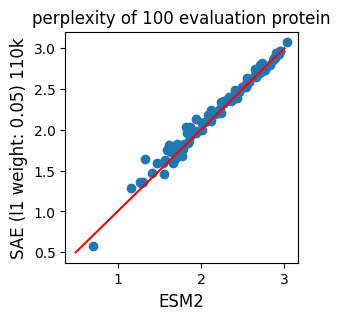

In [39]:
plt.figure(figsize=[3,3])
plt.scatter(esm_ppl, ppls)
plt.plot([0.5,3], [0.5,3], c='red')
plt.title('perplexity of 100 evaluation protein')
plt.xlabel('ESM2', fontsize=12)
plt.ylabel('SAE (l1 weight: 0.05) 110k', fontsize=12)
plt.show()